In [1]:
import numpy as np
import pandas as pd
import glob
from PIL import Image
from matplotlib.pyplot import imshow
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D

def get_images(path,resize = True):  
    img_array = []
    label_array=[]
    img_paths=[]
    fpaths = glob.glob(path, recursive=True)
    
    for fname in fpaths:
        img = Image.open(fname).convert('L')
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
        img_paths.append(fname)
        
        if 'good' in fname.split("/"):
            label_array.append(0)
        else:
            label_array.append(1)
            
    paths=np.array(img_paths)
    images = np.array(img_array)
    labels= np.array(label_array)
    return images,labels,paths



In [2]:
# Autoencoder model

def autoencoder_model():

    input_shape=(64,64,1)
    n_channels = input_shape[-1]
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPool2D(padding='same'))
    model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(MaxPool2D(padding='same'))
    model.add(Conv2D(8, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D())
    model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D())
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(n_channels, (3,3), activation='sigmoid', padding='same'))
    return model

In [3]:
path_train = r"C:\Users\polit\OneDrive\Desktop\MVtec\bottle\train\**\*.*"
path_test = r"C:\Users\polit\OneDrive\Desktop\MVtec\bottle\test\**\*.*"
path_cont_test = r"C:\Users\polit\OneDrive\Desktop\MVtec\bottle\test\contamination\*.*"

all_train,train_labels ,train_paths= get_images(path_train)
test ,test_labels,test_paths= get_images(path_test)
cont_test ,cont_test_labels,cont_test_paths= get_images(path_cont_test)

all_train = all_train.astype('float32') /255.
test = test.astype('float32') / 255.
cont_test = cont_test.astype('float32') / 255.

(train, val) = train_test_split(all_train, shuffle=False, train_size=0.8, random_state=1)
train = train.reshape(train.shape[0], train.shape[1], train.shape[2], 1)
val = val.reshape(val.shape[0], val.shape[1], val.shape[2], 1)
test = test.reshape(test.shape[0], test.shape[1], test.shape[2], 1)
cont_test = cont_test.reshape(cont_test.shape[0], cont_test.shape[1], cont_test.shape[2], 1)


In [4]:
autoencoder = autoencoder_model()
autoencoder.compile(optimizer='adam', loss='mse',metrics=['mae'])
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        1

In [5]:
# fit the model to the data
nb_epochs = 30
batch_size = 10
autoencoder_train = autoencoder.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(val,val))

Epoch 1/30
17/17 [==============================] - 2s 139ms/step - loss: 0.1108 - mae: 0.3173 - val_loss: 0.0816 - val_mae: 0.2700
Epoch 2/30
17/17 [==============================] - 2s 103ms/step - loss: 0.0541 - mae: 0.2014 - val_loss: 0.0264 - val_mae: 0.1229
Epoch 3/30
17/17 [==============================] - 2s 111ms/step - loss: 0.0201 - mae: 0.1052 - val_loss: 0.0140 - val_mae: 0.0906
Epoch 4/30
17/17 [==============================] - 1s 71ms/step - loss: 0.0110 - mae: 0.0801 - val_loss: 0.0092 - val_mae: 0.0719
Epoch 5/30
17/17 [==============================] - 1s 76ms/step - loss: 0.0076 - mae: 0.0634 - val_loss: 0.0068 - val_mae: 0.0577
Epoch 6/30
17/17 [==============================] - 2s 108ms/step - loss: 0.0055 - mae: 0.0518 - val_loss: 0.0049 - val_mae: 0.0462
Epoch 7/30
17/17 [==============================] - 2s 107ms/step - loss: 0.0038 - mae: 0.0407 - val_loss: 0.0033 - val_mae: 0.0362
Epoch 8/30
17/17 [==============================] - 2s 108ms/step - loss: 0.00

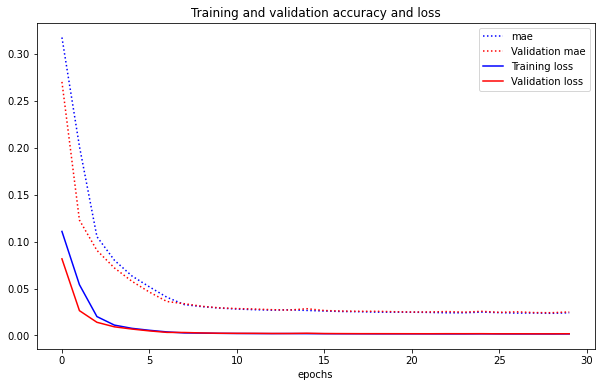

In [6]:
x=range(30)
loss = autoencoder_train.history['loss']
mae = autoencoder_train.history['mae']
val_mae = autoencoder_train.history['val_mae']
val_loss = autoencoder_train.history['val_loss']
plt.figure(figsize=(10,6))
plt.plot(x, mae, 'b:', label='mae')
plt.plot(x, val_mae, 'r:', label='Validation mae')
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy and loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [7]:
def get_error(imgs_true, imgs_pred):
    return np.square(np.subtract(imgs_true, imgs_pred)).mean()
    
          
train_pred = autoencoder.predict(train)
mse_vector=[]
mse_vector_test=[]
mse_vector_cont_test=[]
for i in range(train.shape[0]):
    mse_vector.append( get_error(train_pred[i], train[i]))

threshold = np.quantile(mse_vector, 0.5)

test_pred = autoencoder.predict(test)
cont_test_pred = autoencoder.predict(cont_test)
for i in range(test.shape[0]):
    mse_vector_test.append( get_error(test_pred[i], test[i]))
test_anomaly = (mse_vector_test > threshold)
print(test_anomaly)
for i in range(cont_test.shape[0]):
    mse_vector_cont_test.append( get_error(cont_test_pred[i], cont_test[i]))
cont_test_anomaly = (mse_vector_cont_test > threshold)
print('cont_test_anomaly',cont_test_anomaly)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True False  True  True  True  True
  True  True False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True False  True]
cont_test_anomaly [ True False  True  True  True  True  True  True False False  True  True
  True  True  True  True  True  True  True  True  True]


In [8]:
a = max(mse_vector)

b = min(mse_vector)
c = np.mean(mse_vector)
d = np.quantile(mse_vector, 0.50)

print('maximum value of mse vector is ', a, 'and minimum value is ', b, 'mean value is ', c)
print('\n', '50% quantile = ' , d  )

maximum value of mse vector is  0.0023122756 and minimum value is  0.0012782937 mean value is  0.0016385996

 50% quantile =  0.0016030590049922466


(array([14., 33., 31., 34., 19., 14., 11.,  5.,  3.,  3.]),
 array([0.00127829, 0.00138169, 0.00148509, 0.00158849, 0.00169189,
        0.00179528, 0.00189868, 0.00200208, 0.00210548, 0.00220888,
        0.00231228], dtype=float32),
 <BarContainer object of 10 artists>)

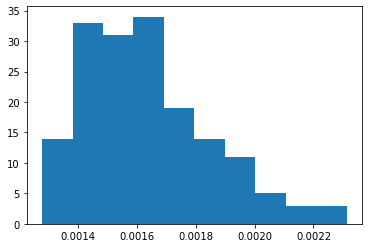

In [9]:
plt.hist(mse_vector)

(array([20., 30., 12.,  7.,  7.,  4.,  0.,  0.,  1.,  2.]),
 array([0.00142592, 0.00181049, 0.00219505, 0.00257962, 0.00296418,
        0.00334875, 0.00373331, 0.00411788, 0.00450244, 0.00488701,
        0.00527157], dtype=float32),
 <BarContainer object of 10 artists>)

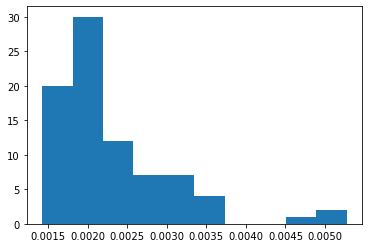

In [10]:
plt.hist(mse_vector_test)

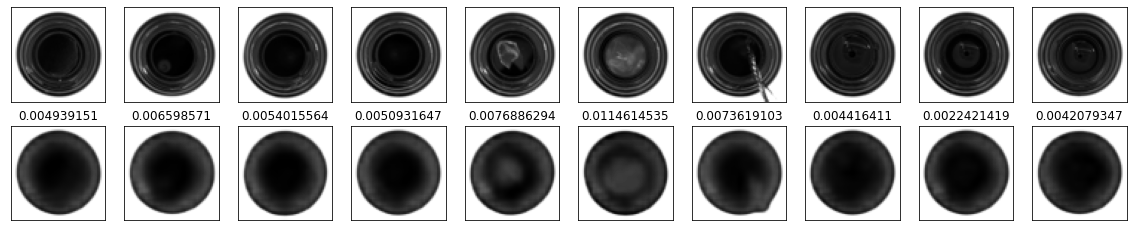

In [11]:
decoded_imgs = autoencoder.predict(cont_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(cont_test[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(get_error(decoded_imgs[i], test[i]))
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
print("Accuracy = {}".format(accuracy_score(test_labels, test_anomaly)))
print("Precision = {}".format(precision_score(test_labels, test_anomaly)))
print("Recall = {}".format(recall_score(test_labels, test_anomaly)))
print( classification_report(test_labels, test_anomaly))

Accuracy = 0.927710843373494
Precision = 1.0
Recall = 0.927710843373494
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.93      0.96        83

    accuracy                           0.93        83
   macro avg       0.50      0.46      0.48        83
weighted avg       1.00      0.93      0.96        83



C:\Users\polit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\polit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\polit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
print("Accuracy = {}".format(accuracy_score(cont_test_labels, cont_test_anomaly)))
print("Precision = {}".format(precision_score(cont_test_labels, cont_test_anomaly)))
print("Recall = {}".format(recall_score(cont_test_labels, cont_test_anomaly)))
print( classification_report(cont_test_labels, cont_test_anomaly))

Accuracy = 0.8571428571428571
Precision = 1.0
Recall = 0.8571428571428571
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.86      0.92        21

    accuracy                           0.86        21
   macro avg       0.50      0.43      0.46        21
weighted avg       1.00      0.86      0.92        21



C:\Users\polit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\polit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\polit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
